# Parts 1 & 2:
### 1. Visualizing the results of different methods.
### 2. Comparing the runtime of each model
### 3. Concluding the best model based on the runtime and visualization

In [136]:
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from torchvision.models import resnet50
from torchvision import transforms
from torchvision.datasets import ImageFolder
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import time

In [137]:
train_data = ImageFolder('imagenette2/train')
val_data = ImageFolder('imagenette2/val')

In [138]:
img1, label1 = train_data[7]

In [139]:
img2, label2 = train_data[3600]

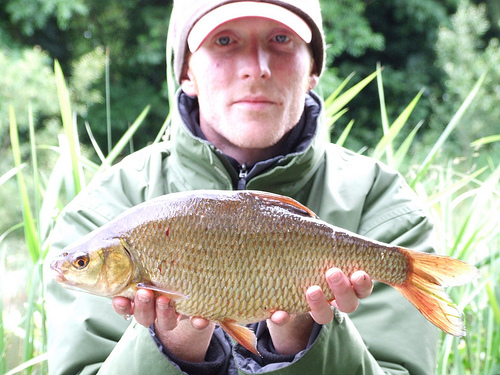

In [141]:
img1

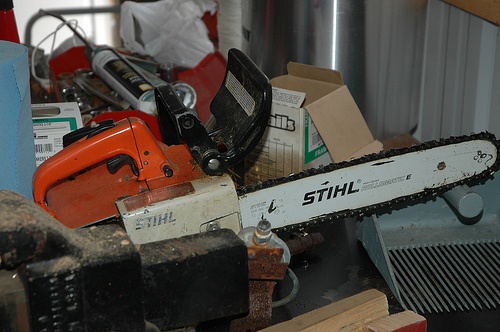

In [142]:
img2

In [143]:
test_transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])
])

In [144]:
tensors = torch.stack([test_transform(img1), test_transform(img2)])

In [145]:
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]

/mnt/new_drive/dls/rl_env/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/new_drive/dls/rl_env/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [146]:
label1, label2

(0, 3)

In [147]:
img1_float = (np.array(img1) / 255).astype(np.float32)
img2_float = (np.array(img2) / 255).astype(np.float32)

In [148]:
labels = [label1, label2]

In [149]:
def get_cam(model, cam_model):
    input_tensor = tensors# Create an input tensor image for your model..
    # Note: input_tensor can be a batch tensor with several images!

    # Construct the CAM object once, and then re-use it on many images:
    cam = cam_model(model=model, target_layers=target_layers, use_cuda=True)

    # You can also use it within a with statement, to make sure it is freed,
    # In case you need to re-create it inside an outer loop:
    # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
    #   ...

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category
    # will be used for every image in the batch.
    # Here we use ClassifierOutputTarget, but you can define your own custom targets
    # That are, for example, combinations of categories, or specific outputs in a non standard model.

    targets = [ClassifierOutputTarget(label1), ClassifierOutputTarget(label2)]
    now = time.time()
    # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    print("TIME: ", time.time() - now)
    cam1 = cv2.resize(grayscale_cam[0], (img1_float.shape[1], img1_float.shape[0]))
    cam2 = cv2.resize(grayscale_cam[1], (img2_float.shape[1], img2_float.shape[0]))
    # In this example grayscale_cam has only one image in the batch:
    visualization1 = show_cam_on_image(img1_float, cam1, use_rgb=True)
    visualization2 = show_cam_on_image(img2_float, cam2, use_rgb=True)
    return visualization1, visualization2


In [150]:
names = ['GradCAM', 'HiResCAM', 'ScoreCAM', 'GradCAMPlusPlus', 'AblationCAM', 'XGradCAM', 'EigenCAM', 'FullGrad']

In [151]:
def show_viz(viz1, viz2):
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches((10, 5))
    ax[0].imshow(viz1)
    ax[1].imshow(viz2)
    fig.suptitle(names[i], fontsize=20)
    plt.show()

TIME:  0.044173240661621094


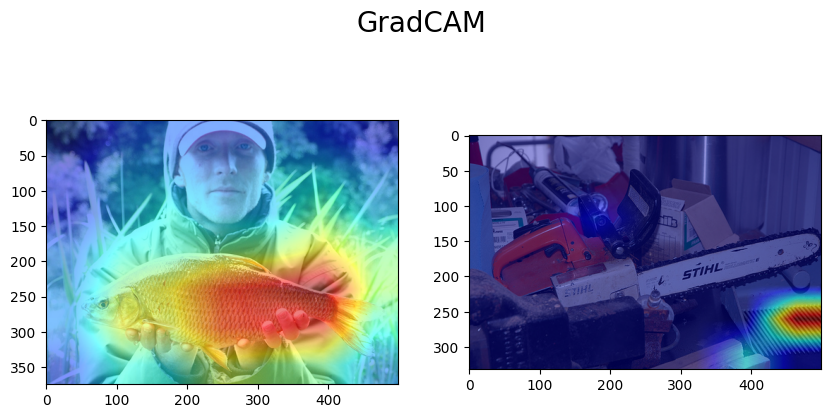

TIME:  0.03678083419799805


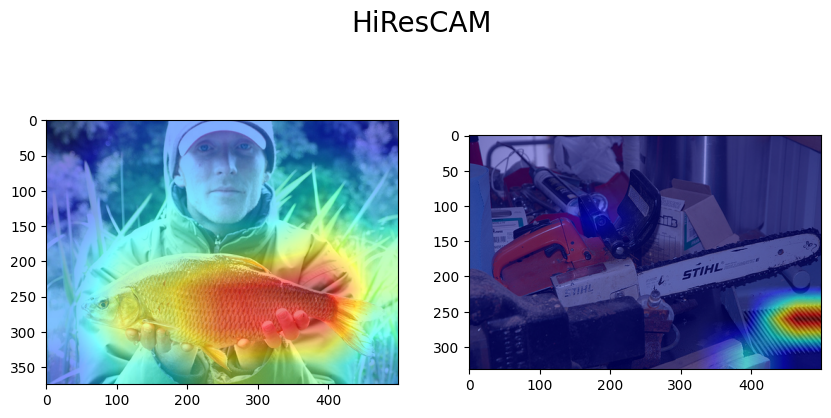

100%|██████████| 128/128 [00:01<00:00, 64.48it/s]
/mnt/new_drive/dls/rl_env/lib/python3.9/site-packages/pytorch_grad_cam/utils/image.py:48: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255 * mask), colormap)


TIME:  4.061981439590454


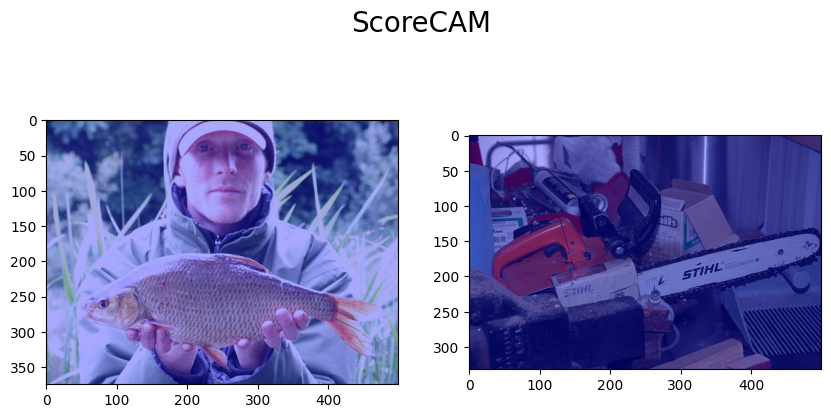

TIME:  0.03889179229736328


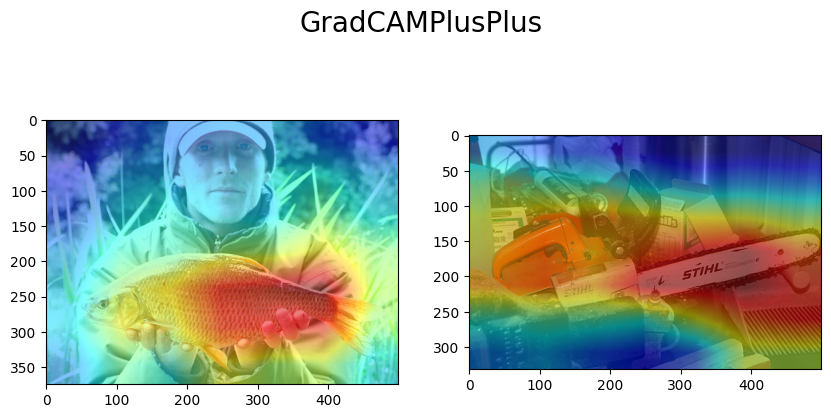

100%|██████████| 64/64 [00:01<00:00, 39.39it/s]


TIME:  3.2921905517578125


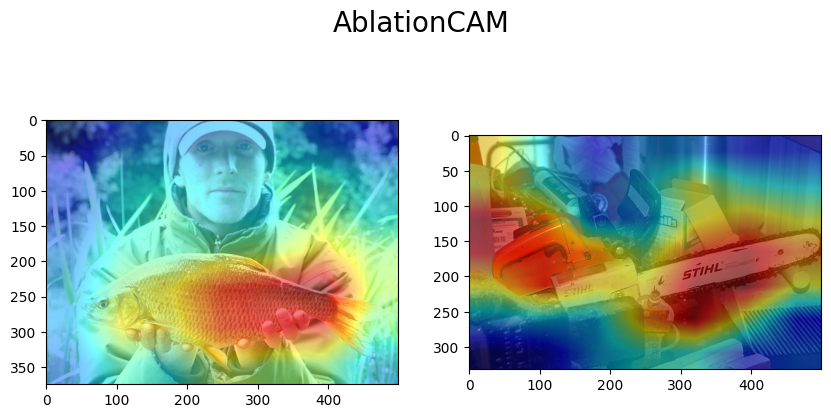

TIME:  0.03755354881286621


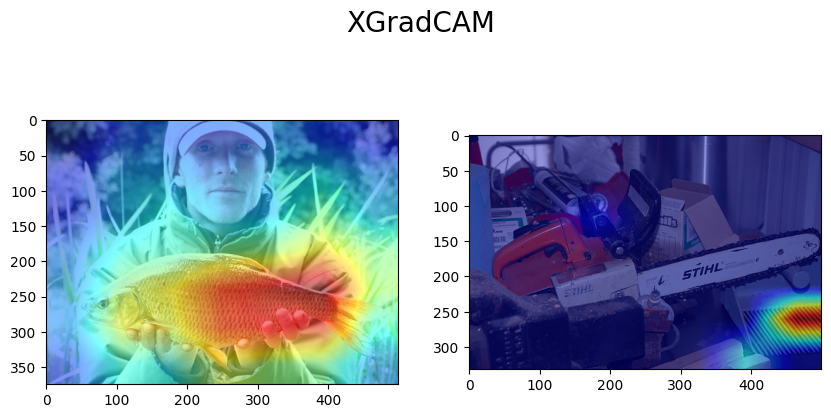

TIME:  0.7450175285339355


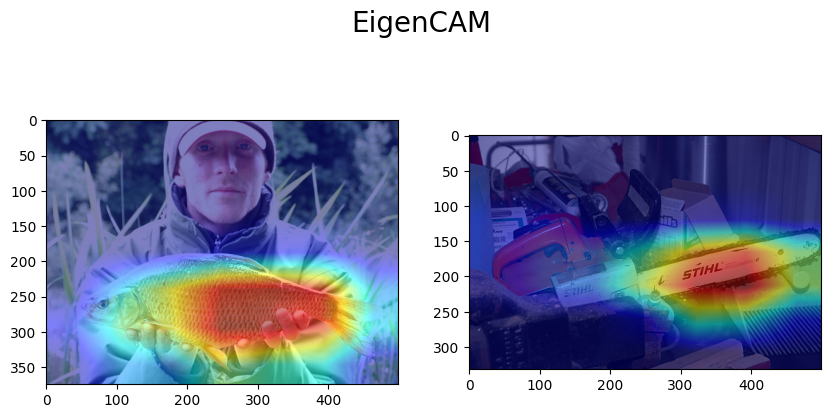

TIME:  11.879364967346191


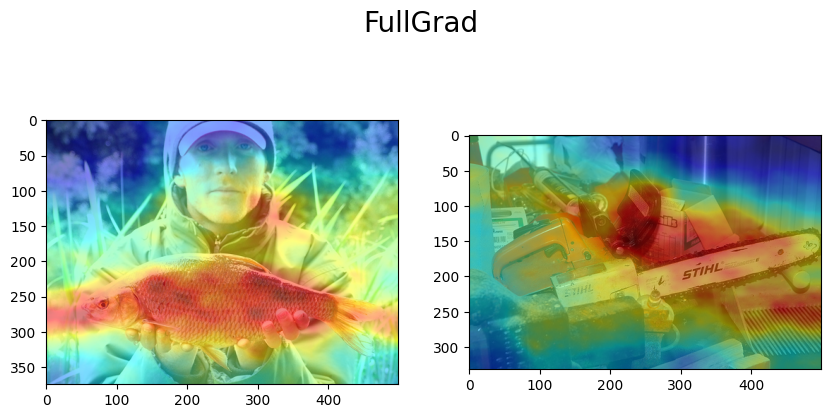

In [152]:
for i, cam_model in enumerate([GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad]):
    viz1, viz2 = get_cam(model, cam_model)
    show_viz(viz1, viz2)

### Comparison:
As we can see fullGrad takes about 11s and ScoreGrad and AblationCAM take around 3~4s.

In the remaining methods, EigenCAM's visualization looks reasonable and takes less that 1s.

Rankings based on runtime:
1. GradCAM, HighresCAM, GradCAM++, XGradCAM ~ 4e-2
2. EigenCAM ~ 1
3. AblationCAM, ScoreCAM ~ 4s
4. FullGradCAM ~ 11s
If runtime is very important, GradCAM++ can also be an option, based on visualizations

# Evaluate Methods

We use Remove and Debias method to evaluate our interpretability methods.

In [153]:
from pytorch_grad_cam.utils.model_targets import ClassifierOutputSoftmaxTarget
from pytorch_grad_cam.metrics.cam_mult_image import CamMultImageConfidenceChange
from pytorch_grad_cam.metrics.road import ROADMostRelevantFirst, ROADLeastRelevantFirst


In [154]:
metric_target = [ClassifierOutputSoftmaxTarget(label1), ClassifierOutputSoftmaxTarget(label2)]
metric_targets = [ClassifierOutputTarget(label1), ClassifierOutputTarget(label2)]

In [171]:
_ = model.to('cpu')

In [172]:
def get_cam_eval(model, cam_model):
    input_tensor = tensors# Create an input tensor image for your model..
    # Note: input_tensor can be a batch tensor with several images!

    # Construct the CAM object once, and then re-use it on many images:
    cam = cam_model(model=model, target_layers=target_layers, use_cuda=False)

    # You can also use it within a with statement, to make sure it is freed,
    # In case you need to re-create it inside an outer loop:
    # with GradCAM(model=model, target_layers=target_layers, use_cuda=args.use_cuda) as cam:
    #   ...

    # We have to specify the target we want to generate
    # the Class Activation Maps for.
    # If targets is None, the highest scoring category
    # will be used for every image in the batch.
    # Here we use ClassifierOutputTarget, but you can define your own custom targets
    # That are, for example, combinations of categories, or specific outputs in a non standard model.

    targets = [ClassifierOutputTarget(label1), ClassifierOutputTarget(label2)]
    grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
    # State of the art metric: Remove and Debias
    cam_metric = ROADMostRelevantFirst(percentile=75)
    scores, perturbation_visualizations = cam_metric(input_tensor, grayscale_cam, targets, model, return_visualization=True)    
    viz1 = perturbation_visualizations[0] * torch.tensor([[[0.229]], [[0.224]], [[0.225]]]) + torch.tensor([[[0.485]], [[0.456]], [[0.406]]])
    viz2 = perturbation_visualizations[1] * torch.tensor([[[0.229]], [[0.224]], [[0.225]]]) + torch.tensor([[[0.485]], [[0.456]], [[0.406]]])    # In this example grayscale_cam has only one image in the batch:
    viz1 = viz1.permute(1, 2, 0).cpu().numpy()
    viz2 = viz2.permute(1, 2, 0).cpu().numpy()
    return scores, viz1, viz2


In [173]:
# cam = cam_model(model=model, target_layers=target_layers, use_cuda=True)
# input_tensor = tensors
# grayscale_cam = cam(input_tensor=input_tensor, targets=targets)
# cam1 = cv2.resize(grayscale_cam[0], (img1_float.shape[1], img1_float.shape[0]))
# cam2 = cv2.resize(grayscale_cam[1], (img2_float.shape[1], img2_float.shape[0]))

In [174]:
# # Create the metric target, often the confidence drop in a score of some category
# scores, batch_visualizations = CamMultImageConfidenceChange()(tensors, 
#   grayscale_cam, targets, model, return_visualization=True)


In [175]:
# viz1 = batch_visualizations[0] * torch.tensor([[[0.229]], [[0.224]], [[0.225]]]) + torch.tensor([[[0.485]], [[0.456]], [[0.406]]])
# viz2 = batch_visualizations[1] * torch.tensor([[[0.229]], [[0.224]], [[0.225]]]) + torch.tensor([[[0.485]], [[0.456]], [[0.406]]])

In [176]:
# viz1 = viz1.permute(1, 2, 0).cpu().numpy()
# viz2 = viz2.permute(1, 2, 0).cpu().numpy()

In [177]:
# show_viz(viz1, viz2)

[-5.25185    2.1329393]


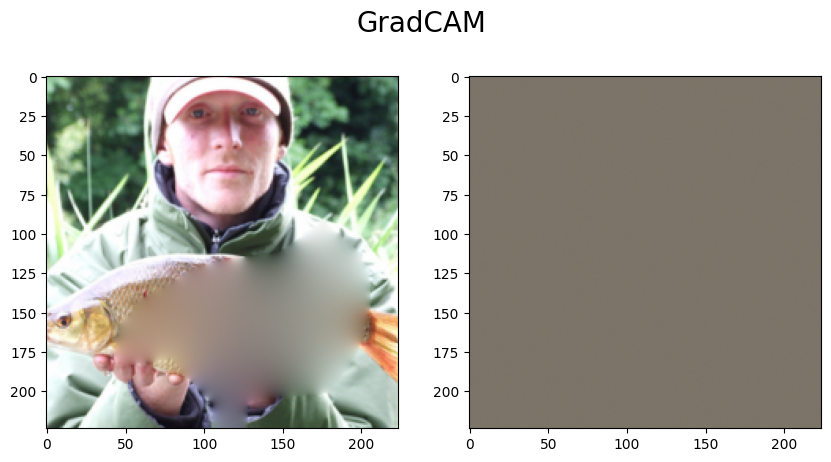

[-5.097494   2.0874534]


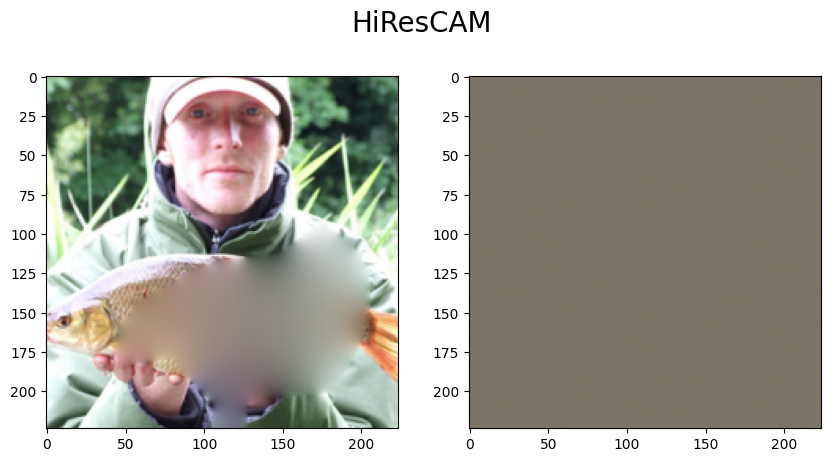

100%|██████████| 128/128 [03:21<00:00,  1.57s/it]


[-19.027615    2.0083537]


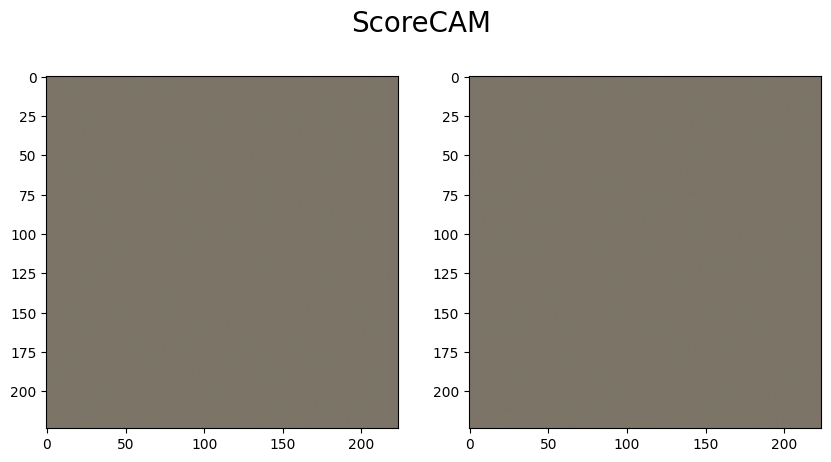

[-5.019207   1.0440676]


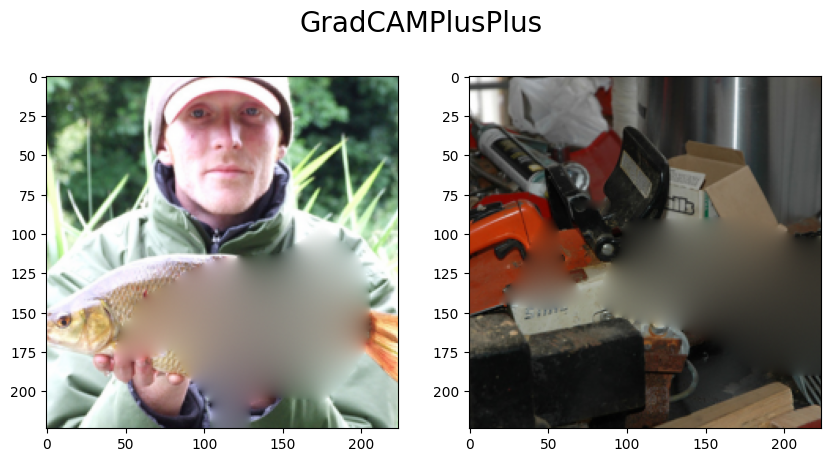

100%|██████████| 64/64 [02:06<00:00,  1.97s/it]


[-5.255864  -0.9220576]


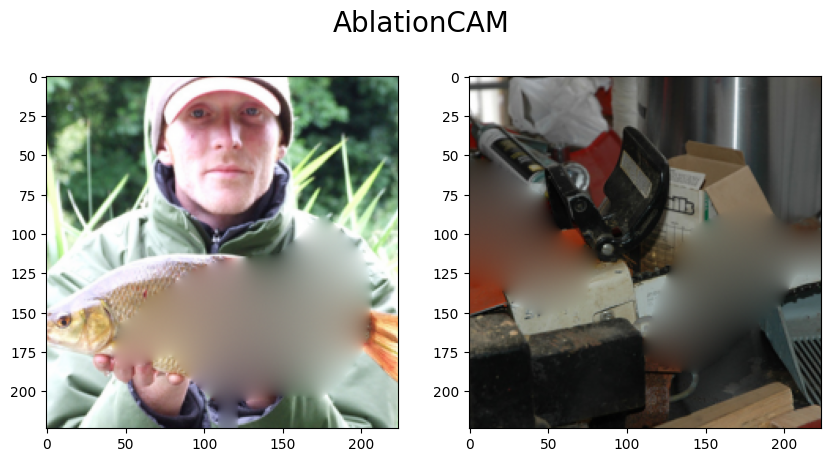

[-5.1656647  2.0968242]


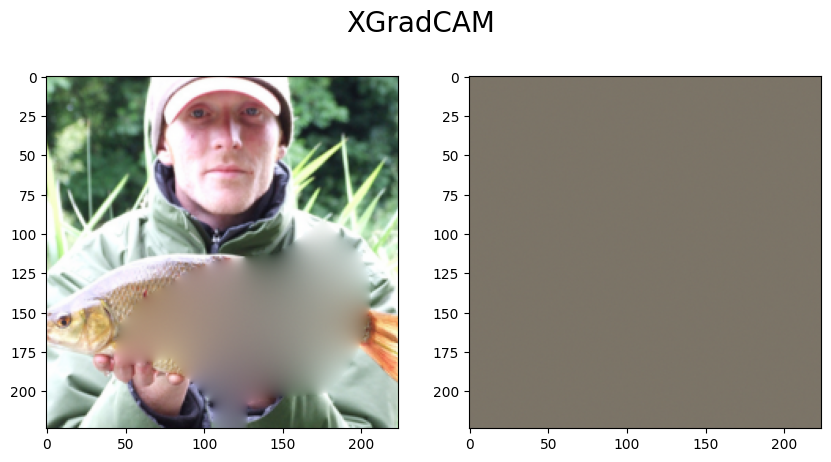

[-6.083459  -0.9085176]


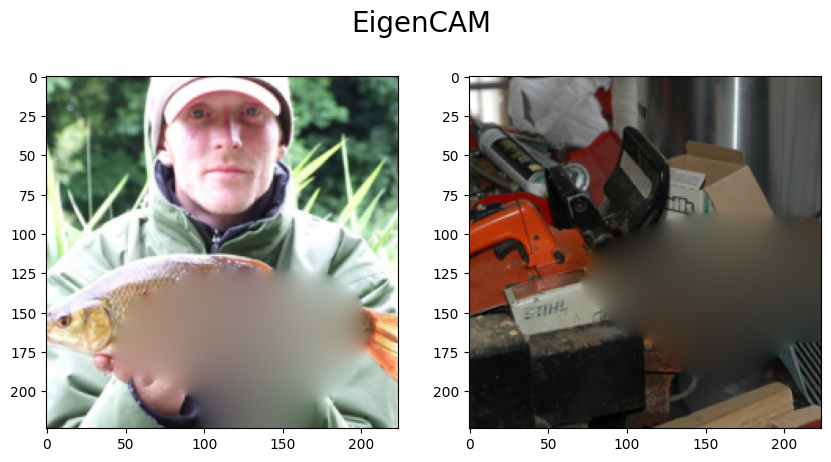

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[-7.836747    0.20666695]


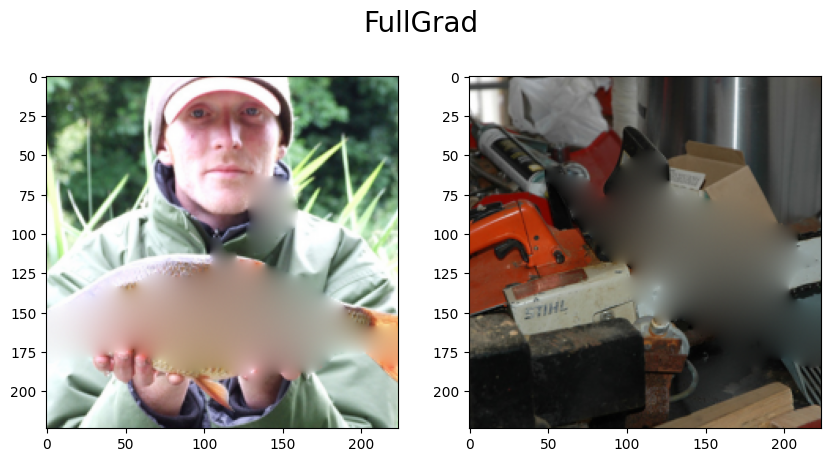

In [179]:
for i, cam_model in enumerate([GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad]):
    scores, viz1, viz2 = get_cam_eval(model, cam_model)
    print(scores)
    show_viz(viz1, viz2)


Results 

[-5.25185    2.1329393]

[-5.097494   2.0874534]

[-19.027615    2.0083537]

[-5.019207   1.0440676]

[-5.255864  -0.9220576]

[-5.1656647  2.0968242]

[-6.083459  -0.9085176]

[-7.836747    0.20666695]